## Import Libraries

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import empiricaldist
import scipy
import statsmodels.formula.api as smf

## Config

In [117]:
# Settings
sns.set()
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.options.display.float_format= '{:.2f}'.format

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

Title_fontsize= 16

In [118]:
laptop = pd.read_csv('./data/laptop-EDA.csv')
laptop.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
0,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1339.69,2560,1600,1,Intel,2.30,128,SSD
1,Apple,Ultrabook,13.30,8,Intel,macOS,1.34,898.94,1440,900,0,Intel,1.80,128,Flash
2,HP,Notebook,15.60,8,Intel,No OS,1.86,575.00,1920,1080,0,Intel,2.50,256,SSD
3,Apple,Ultrabook,15.40,16,AMD,macOS,1.83,2537.45,2880,1800,1,Intel,2.70,512,SSD
4,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1803.60,2560,1600,1,Intel,3.10,256,SSD


In [119]:
print('The dataset contain {} rows and {} columns'.format(laptop.shape[0],laptop.shape[1]))

The dataset contain 1302 rows and 15 columns


In [120]:
laptop = (
    laptop.astype({
        'IPS Panel': 'bool'
        })
)

In [121]:
(
    laptop
    .dtypes
    .value_counts()
)

object     6
float64    4
int64      4
bool       1
dtype: int64

In [122]:
def Zerovalues(df):
    d = {'TotalRecord': df.shape[0], '#Zeros':0, '%Zeros':0}
    y = pd.DataFrame(d, index= df.columns)
     
    for c  in df.columns:
         y.loc[c,"#Zeros"] = len(df[df[c]==0])
         y.loc[c,"%Zeros"] = round((y.loc[c,"#Zeros"] / y.loc[c,"TotalRecord"] ),2) * 100
    return y[y["#Zeros"]>0]

Zerovalues(laptop)

,TotalRecord,#Zeros,%Zeros
IPS Panel,1302,938,72


# Univariate Analysis

### Categorical variables - Analysis

In [123]:
laptop.describe(include='object').transpose()

,count,unique,top,freq
Company,1302,9,Dell,297
TypeName,1302,6,Notebook,727
Gpu,1302,3,Intel,722
OpSys,1302,7,Windows 10,1080
CPU Brand,1302,2,Intel,1240
MemoryType,1302,4,SSD,843


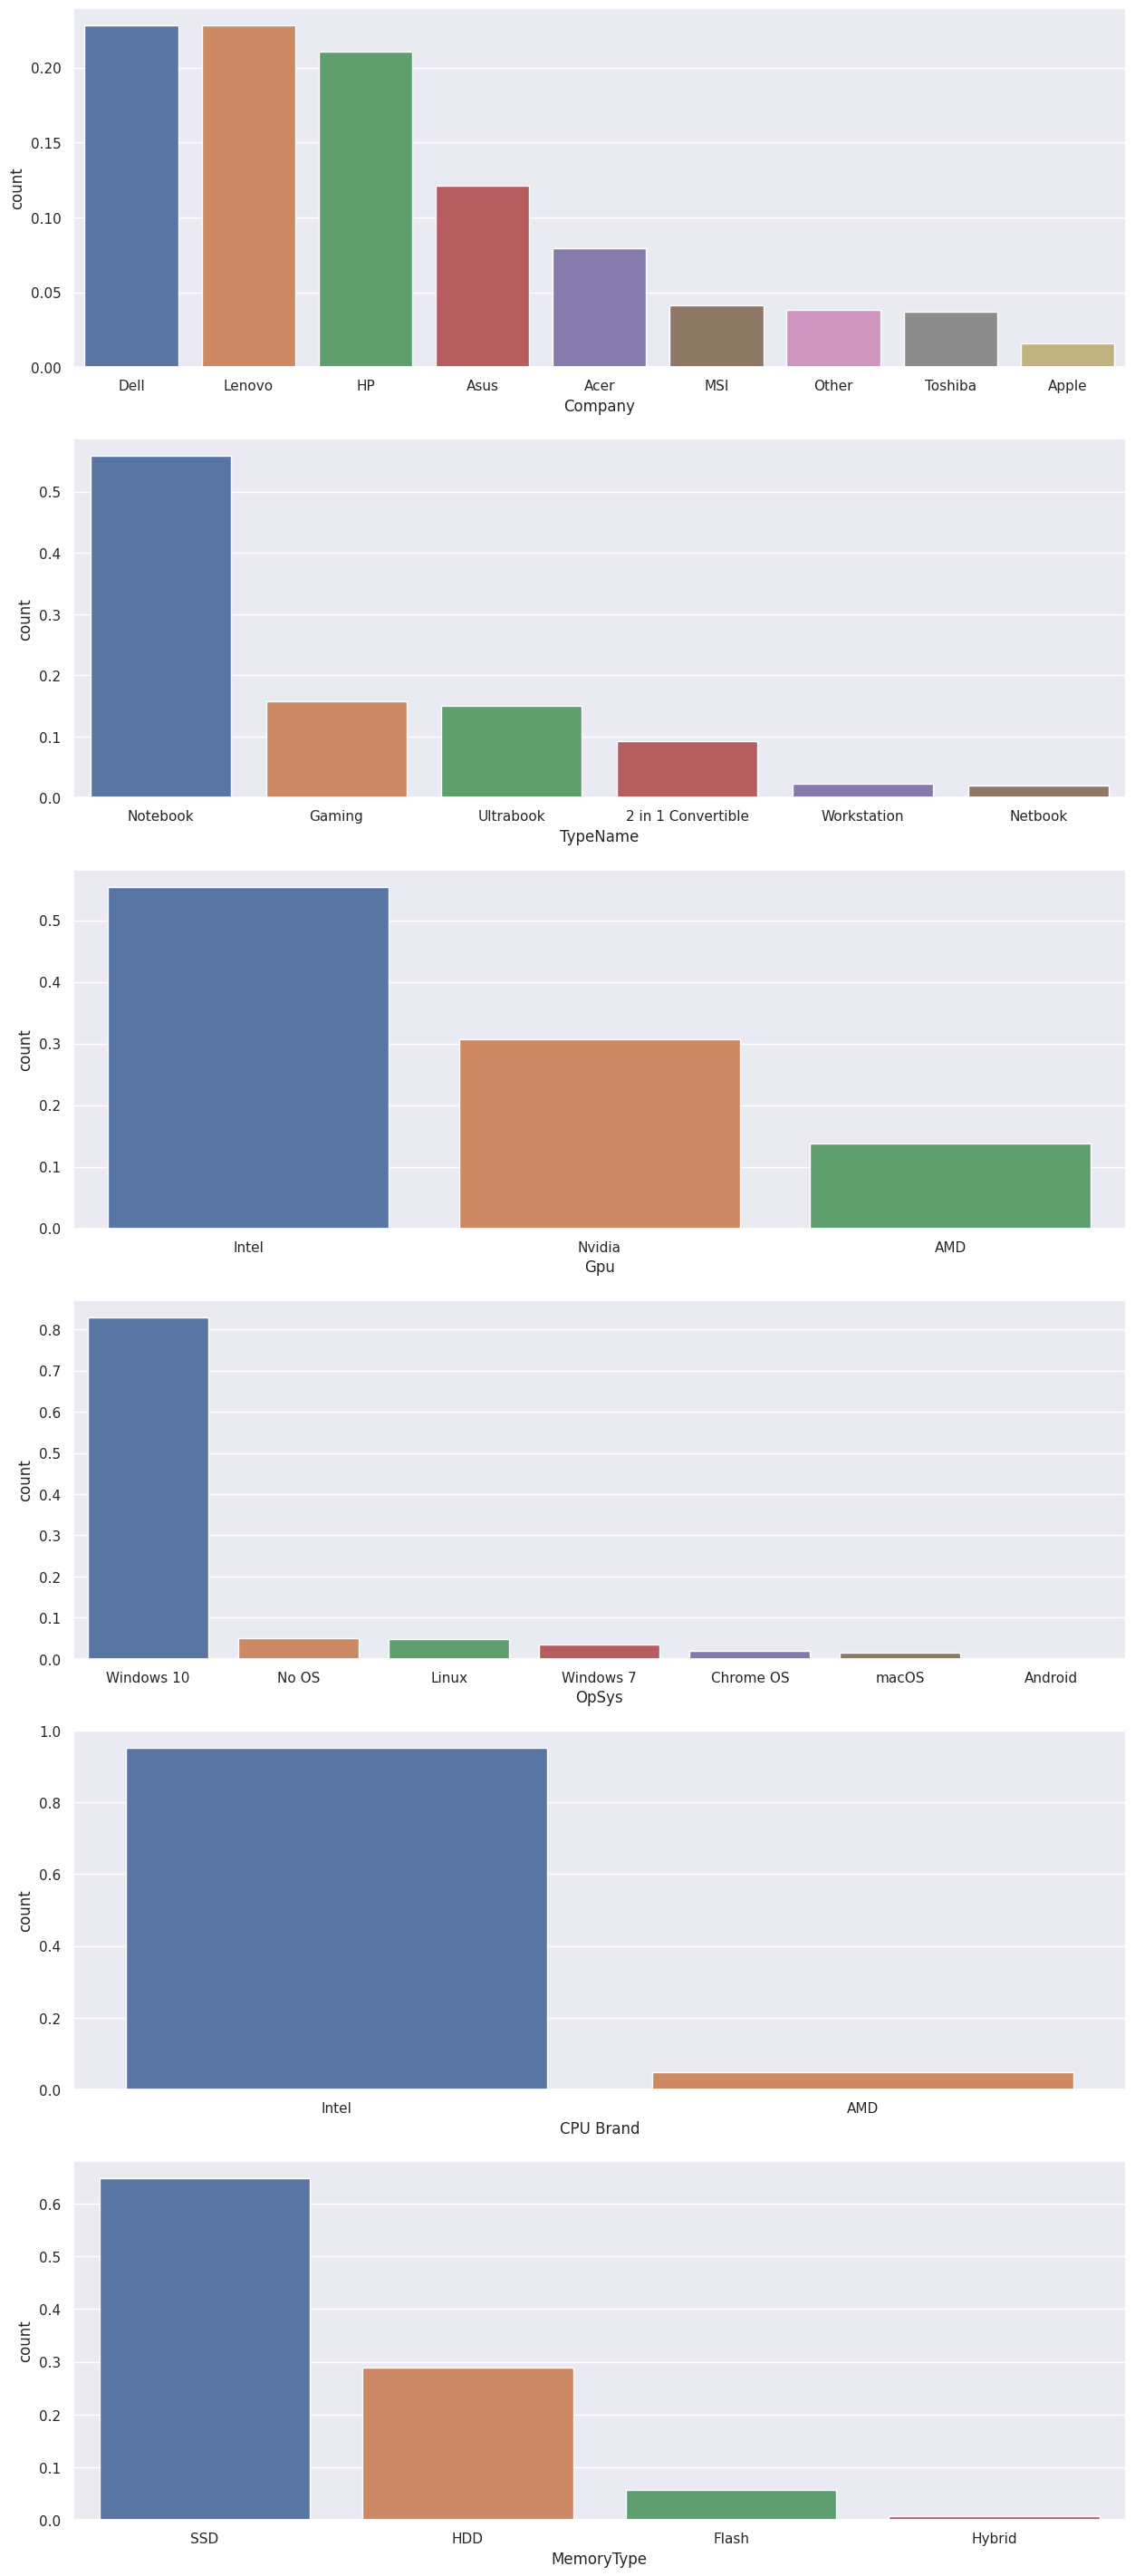

In [124]:
categories=laptop.select_dtypes(include='object').columns
fig, ax = plt.subplots(len(categories),1,figsize=(15,len(categories)*6))
for i in range(len(categories)):
    (
        laptop
        .value_counts(categories[i],sort=True,normalize=True)
        .reset_index(name='count')
        .pipe(
            lambda df_count:(
                sns.barplot(
                    ax=ax[i],
                    data=df_count,
                    x = categories[i],
                    y='count'
                )
            )
                
        )
    )

In [125]:
def pivot_table(data,columns,count):

    for column in columns:
        d = data.pivot_table(index= column, values=count, margins=True,margins_name='Total',aggfunc='count')
        d['%']=d/data.shape[0]
        d['%']=round(d['%'].astype(float),2)
        print(column)
        print('')
        print(d.sort_values(by=count,ascending=True))
        print('\n')

categories = laptop.select_dtypes(include='object')
pivot_table(laptop,categories,'Price_euros')

Company

         Price_euros    %
Company                  
Apple             21 0.02
Toshiba           48 0.04
Other             50 0.04
MSI               54 0.04
Acer             103 0.08
Asus             158 0.12
HP               274 0.21
Dell             297 0.23
Lenovo           297 0.23
Total           1302 1.00


TypeName

                    Price_euros    %
TypeName                            
Netbook                      25 0.02
Workstation                  29 0.02
2 in 1 Convertible          120 0.09
Ultrabook                   196 0.15
Gaming                      205 0.16
Notebook                    727 0.56
Total                      1302 1.00


Gpu

        Price_euros    %
Gpu                     
AMD             180 0.14
Nvidia          400 0.31
Intel           722 0.55
Total          1302 1.00


OpSys

            Price_euros    %
OpSys                       
Android               2 0.00
macOS                21 0.02
Chrome OS            26 0.02
Windows 7            45

### Measures of dispersion

In [126]:
laptop.describe(include=np.number).transpose()

,count,mean,std,min,25%,50%,75%,max
Inches,1302.00,15.02,1.42,10.10,14.00,15.60,15.60,18.40
Ram,1302.00,8.39,5.09,2.00,4.00,8.00,8.00,64.00
Weight,1302.00,2.04,0.67,0.69,1.50,2.04,2.30,4.70
Price_euros,1302.00,1124.04,699.16,174.00,599.00,978.00,1488.43,6099.00
screen_width,1302.00,1894.40,494.63,1366.00,1600.00,1920.00,1920.00,3840.00
screen_height,1302.00,1070.42,284.25,768.00,900.00,1080.00,1080.00,2160.00
CPU GHz,1302.00,2.30,0.51,0.90,2.00,2.50,2.70,3.60
MemoryAmount,1302.00,442.93,356.18,8.00,256.00,256.00,512.00,2000.00


In [127]:
def hist_boxplot(df):
    numeric_columns = df.select_dtypes(include=np.number)
    for column in numeric_columns:
        plt.figure(figsize=(11,5))
        sns.histplot(
            data=df,
            x=column,
            stat='probability'
        )
        plt.axvline(
            x=df[column].mean(),
            color='red',
            linestyle='--',
            linewidth=2)
        plt.axvline(
        x= df[column].quantile(q=0.25),
            color='green',
            linestyle='--',
            linewidth=2
        )
        plt.axvline(
        x= df[column].quantile(q=0.75),
            color='green',
            linestyle='--',
            linewidth=2
        )
        plt.title(column+' - Histogram',fontsize=16)
        plt.show()
        plt.figure(figsize=(11,5))
        sns.boxplot(data=df
                    ,x=column)
        plt.title(column+' - Boxplot',fontsize=Title_fontsize)
        plt.show()

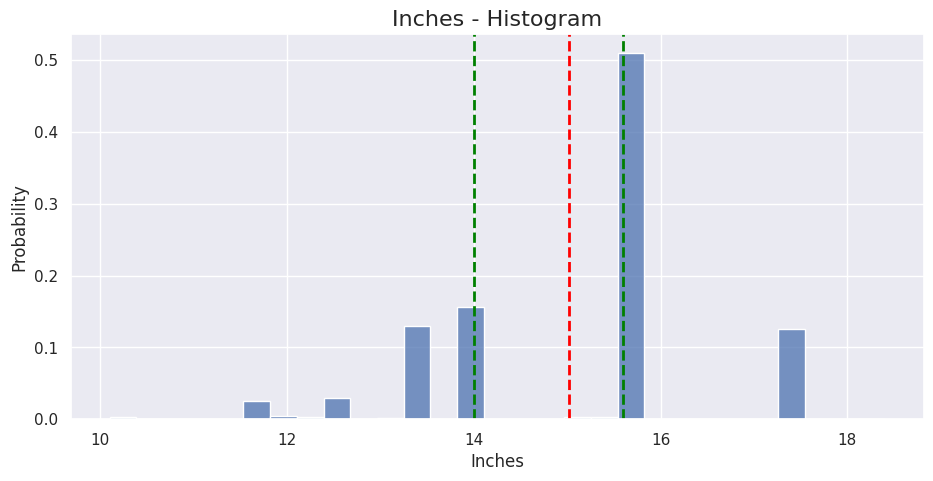

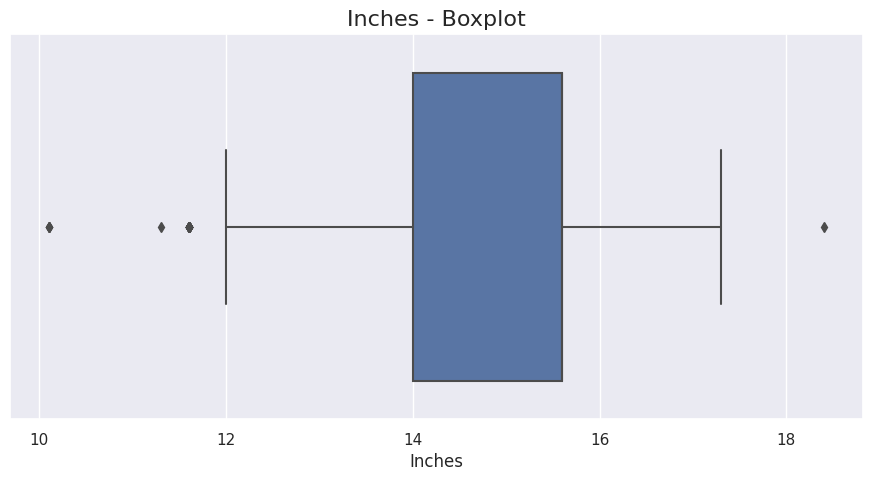

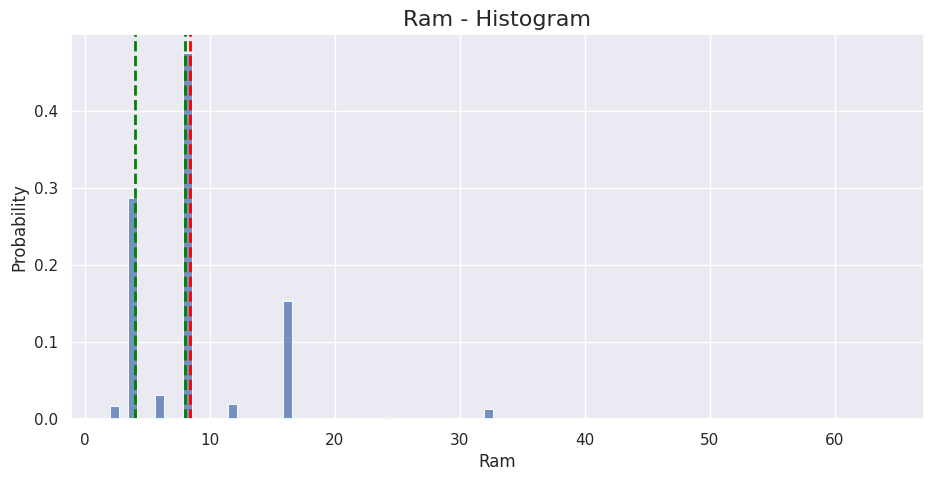

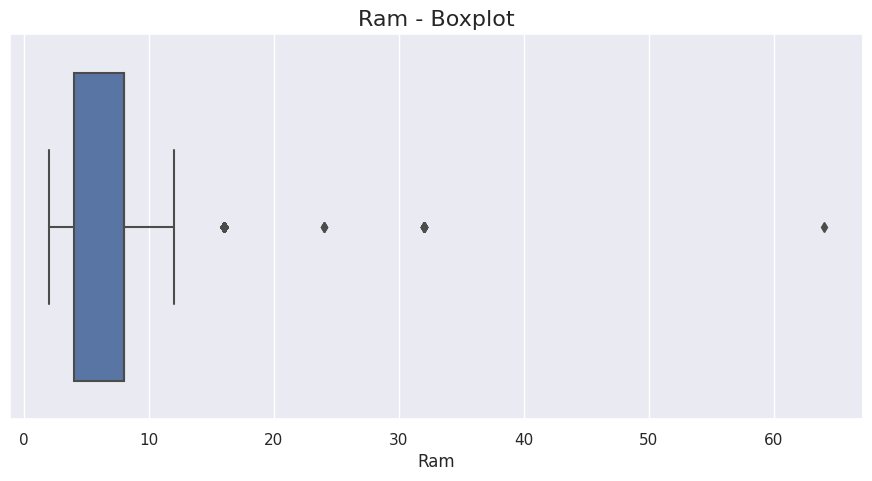

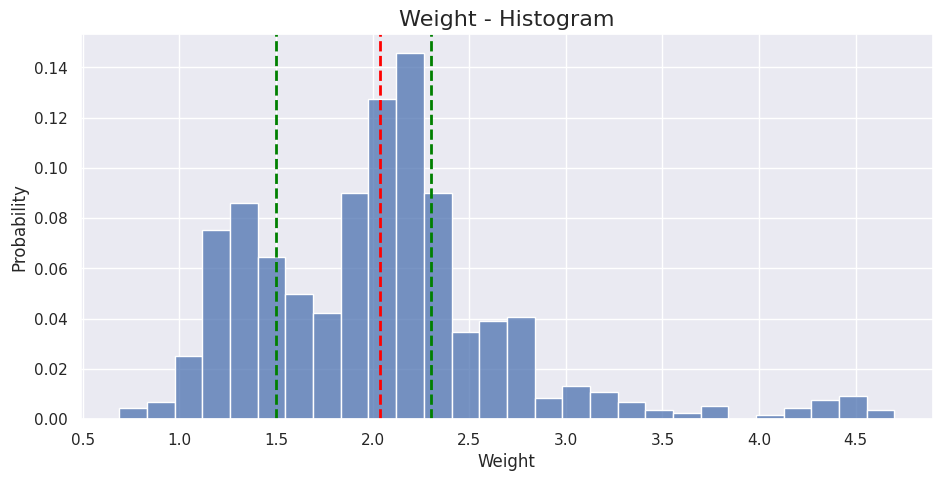

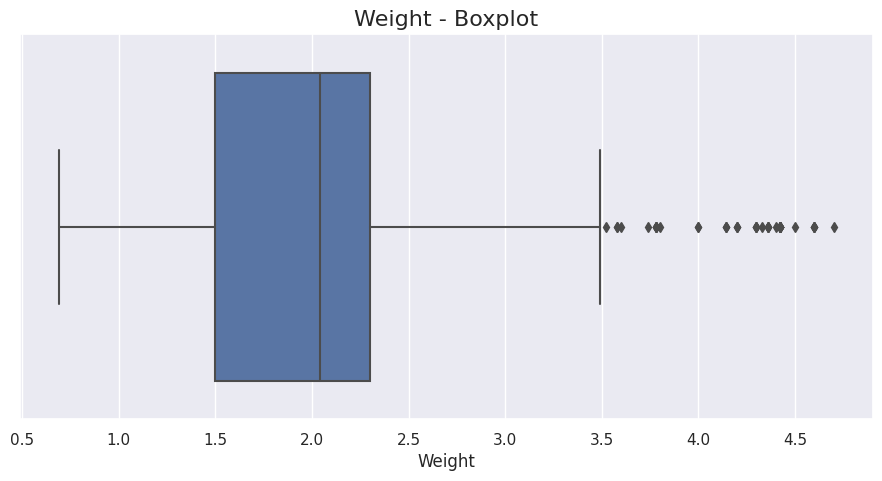

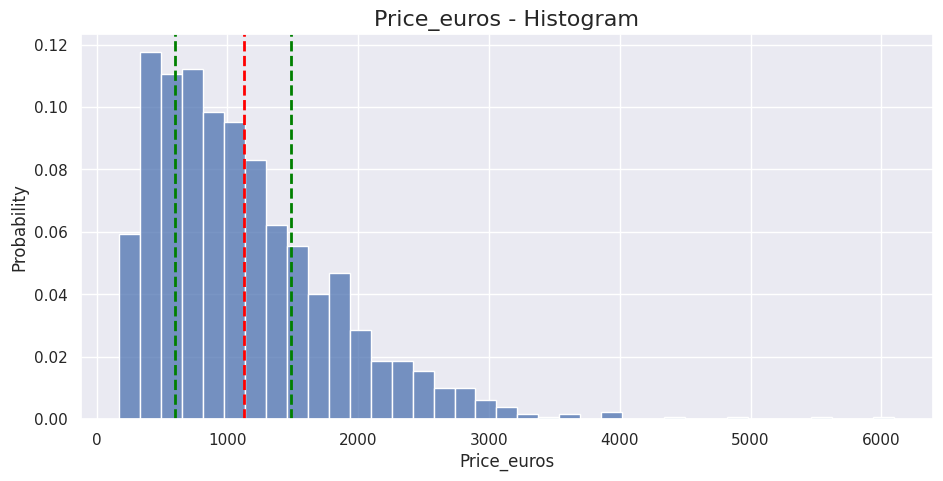

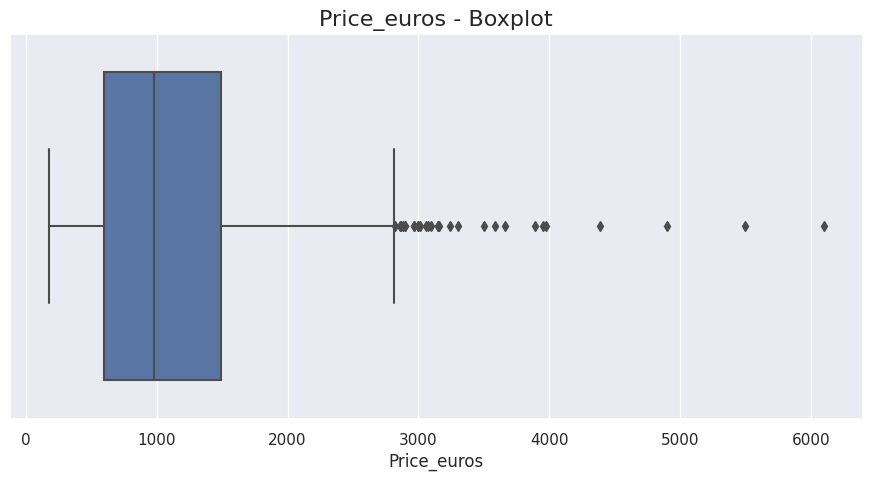

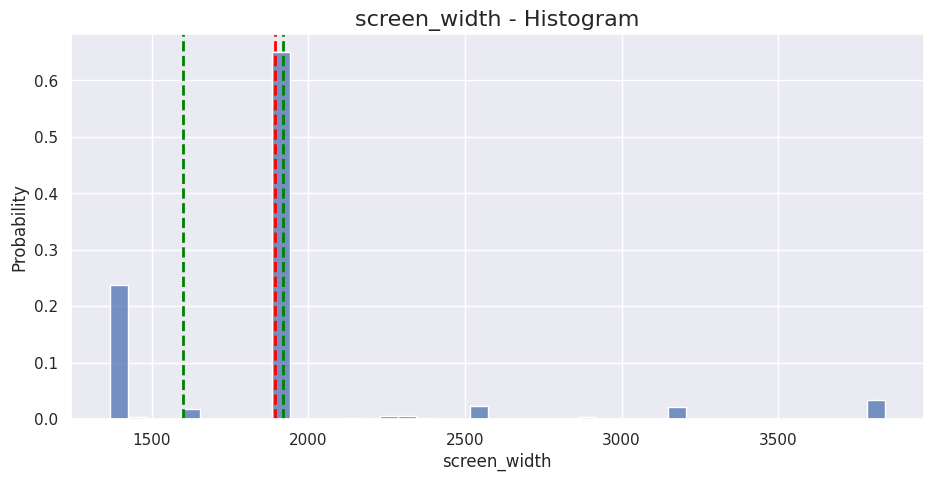

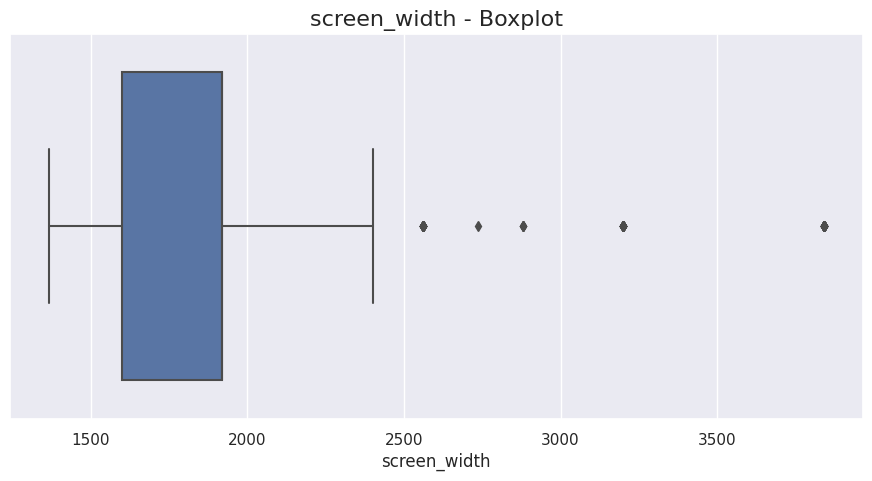

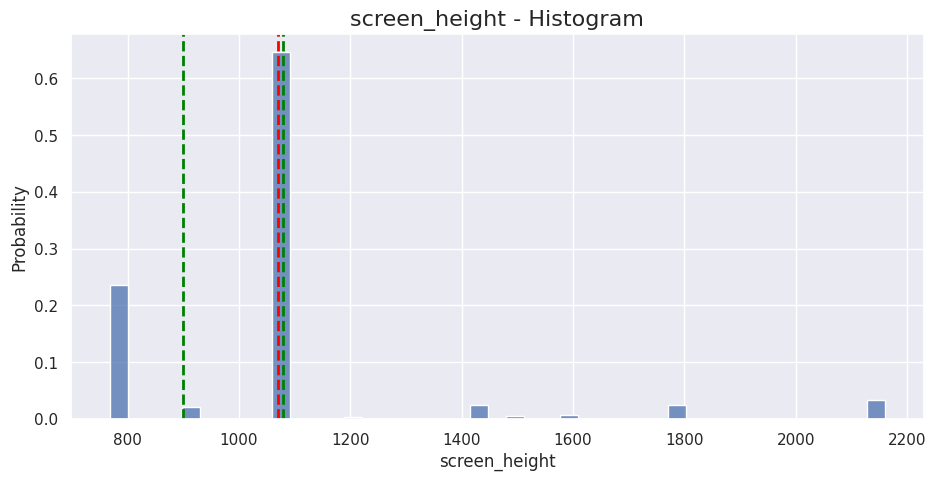

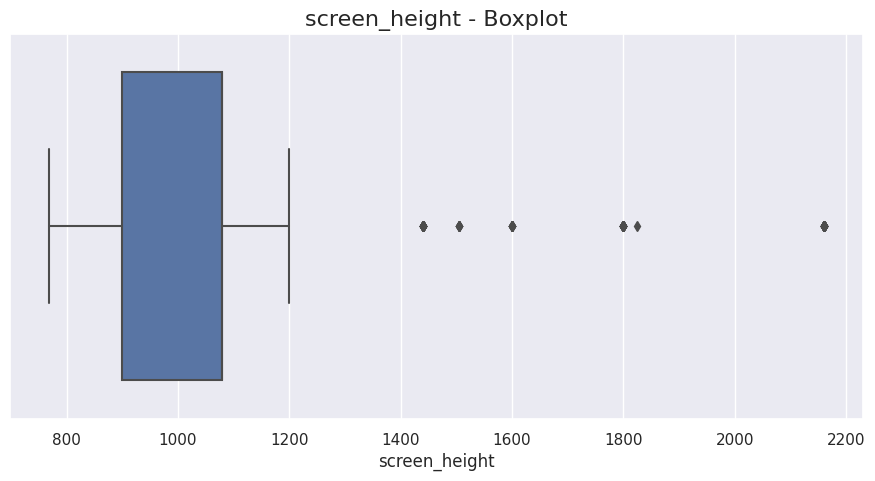

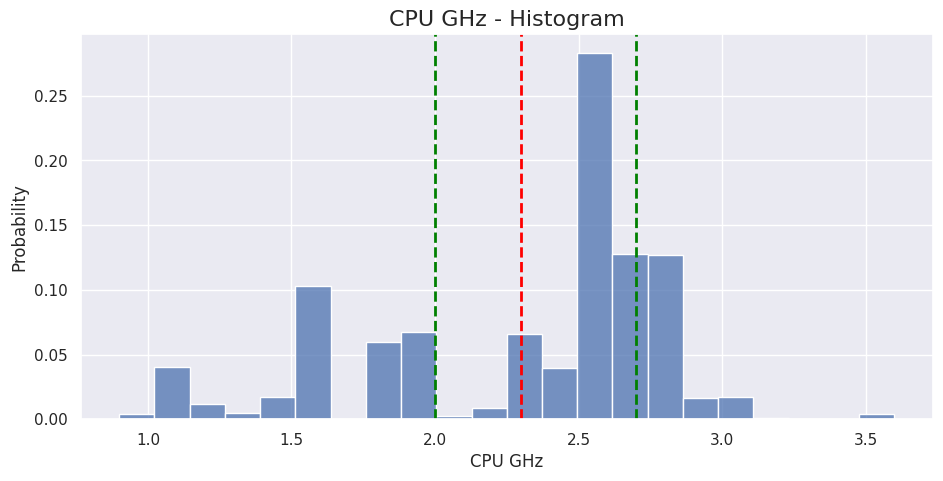

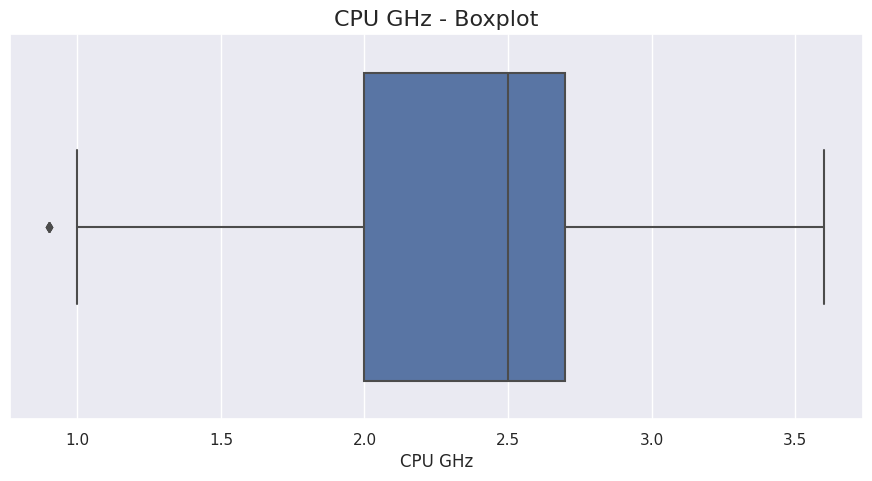

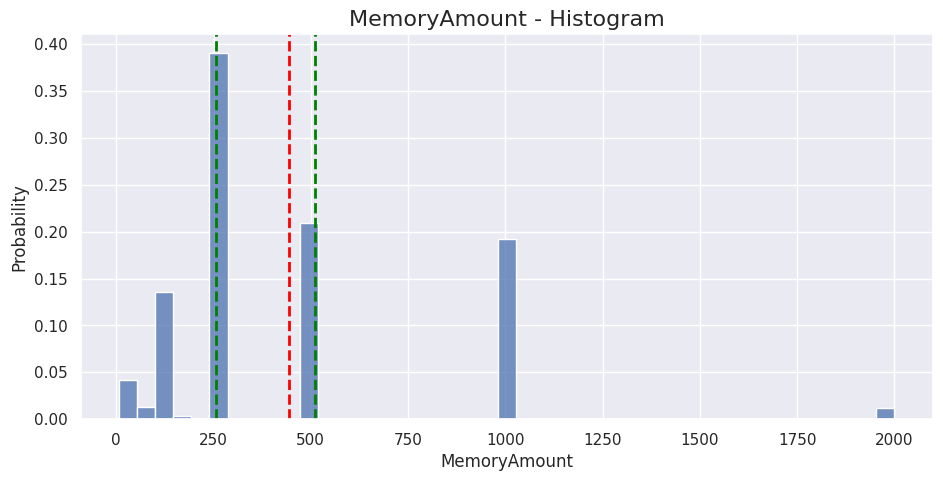

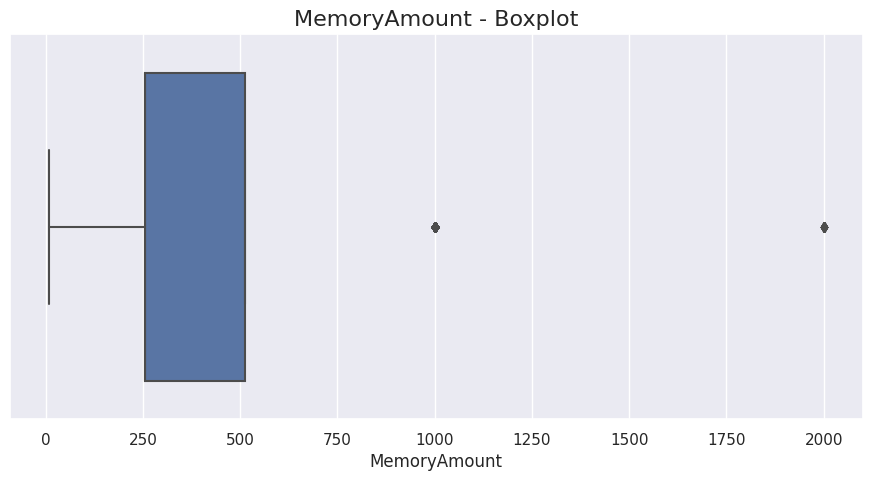

In [128]:
hist_boxplot(df=laptop)

<AxesSubplot:xlabel='Price_euros', ylabel='Probability'>

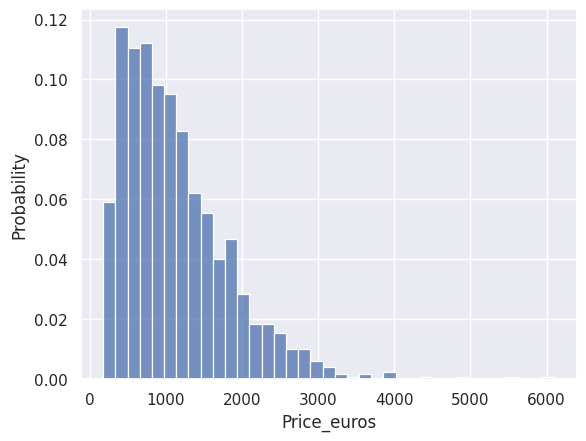

In [129]:
sns.histplot(
    data=laptop,
    x='Price_euros',
    stat='probability'
)

## Empirical cumulative probability functions and density function

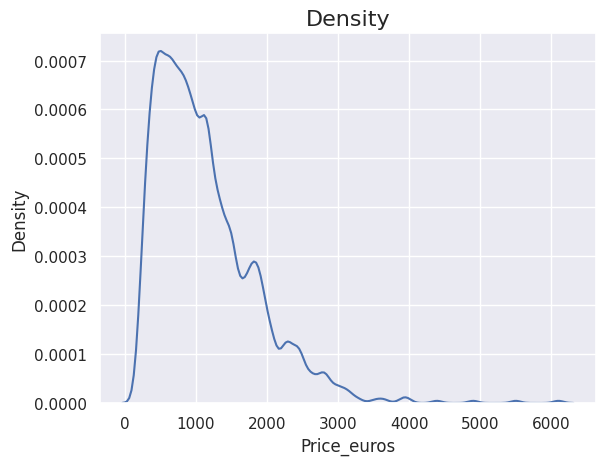

In [130]:
sns.kdeplot(
    data=laptop,
    x='Price_euros',
    bw_method=0.1
)
plt.title('Density',fontsize=Title_fontsize)
plt.show()

Text(0.5, 1.0, 'Cummulative function')

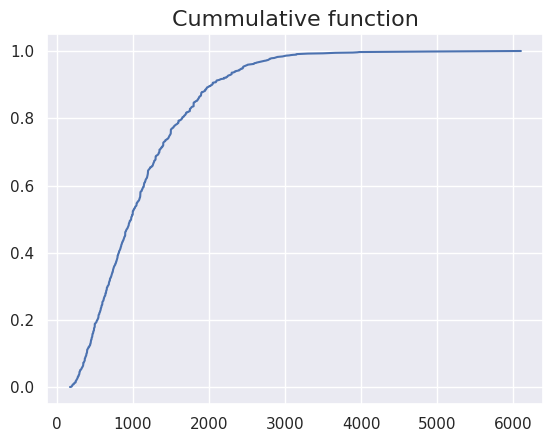

In [131]:
cmd_flipper_length=empiricaldist.Cdf.from_seq(
    laptop['Price_euros'],
    normalize=True
).plot()
plt.title('Cummulative function',fontsize=Title_fontsize)

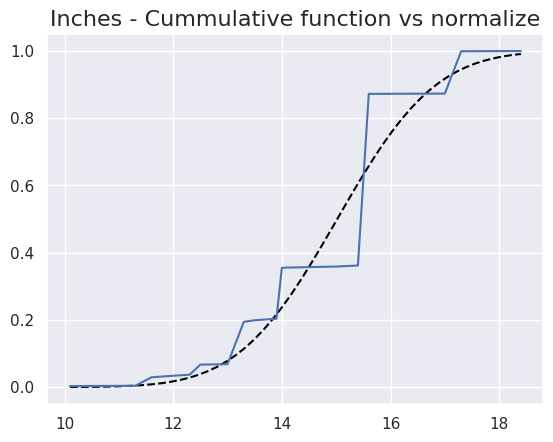

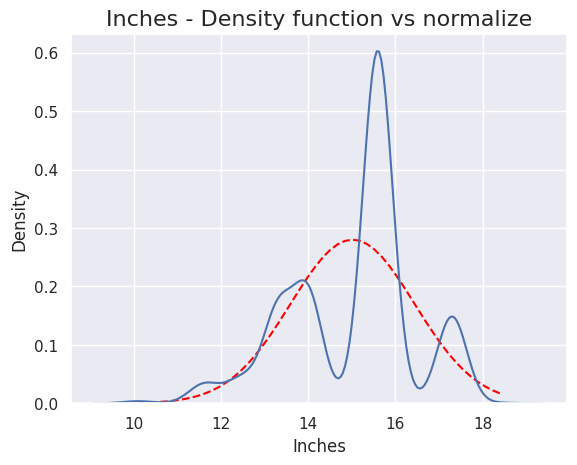

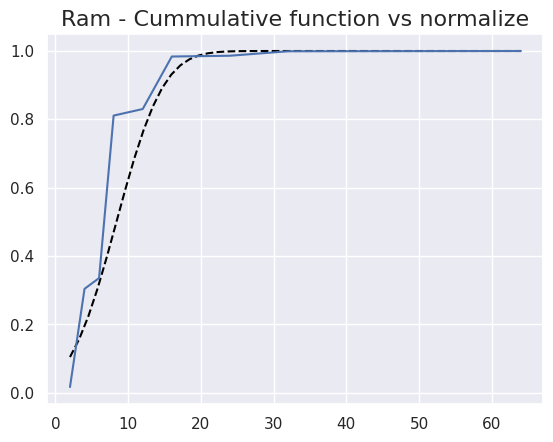

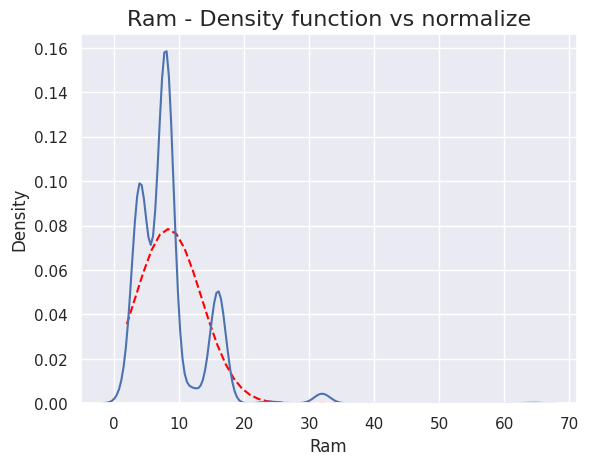

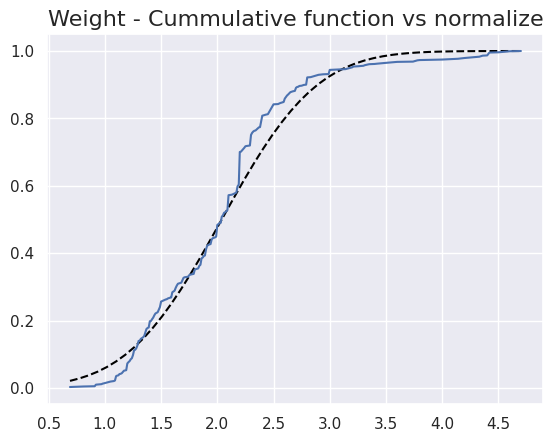

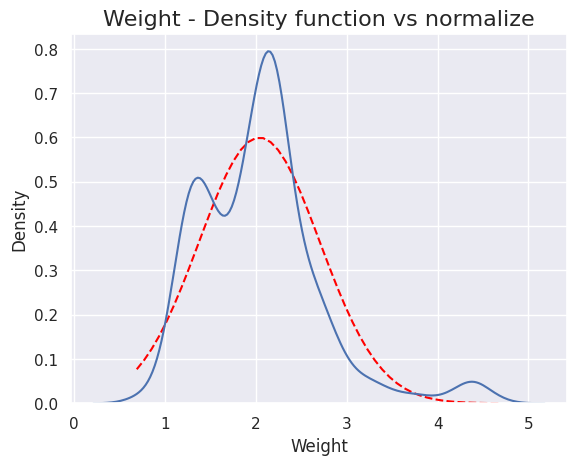

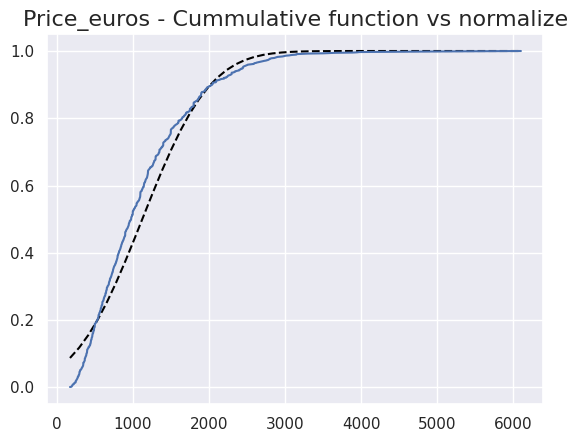

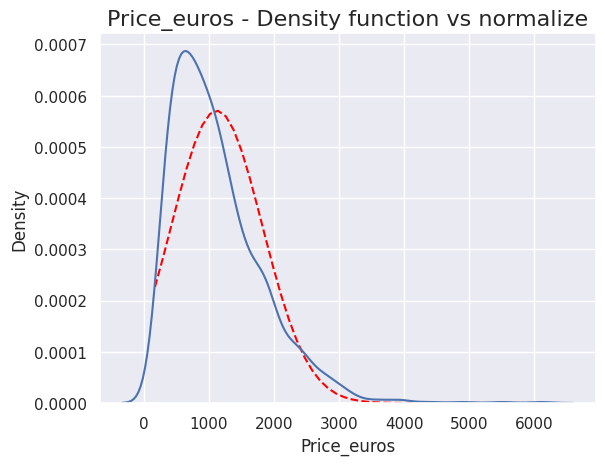

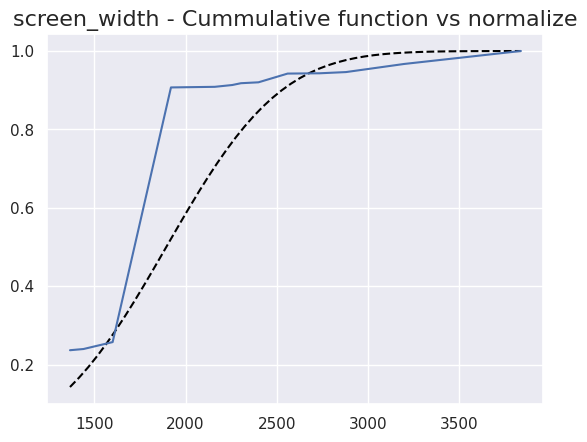

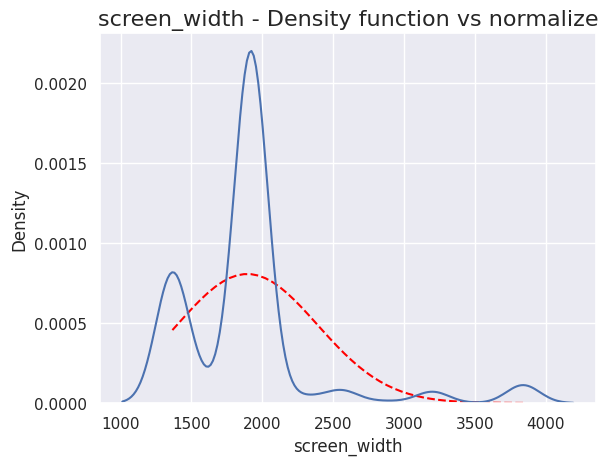

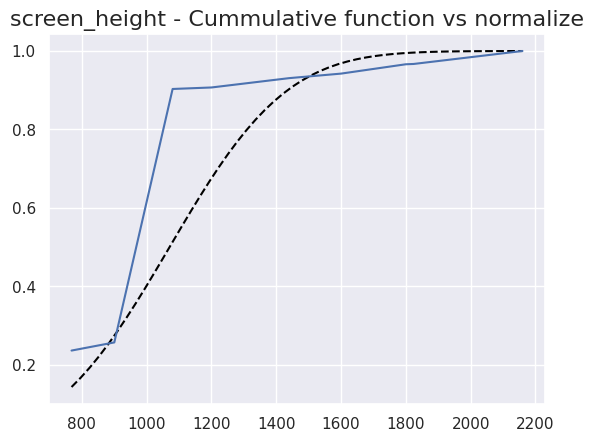

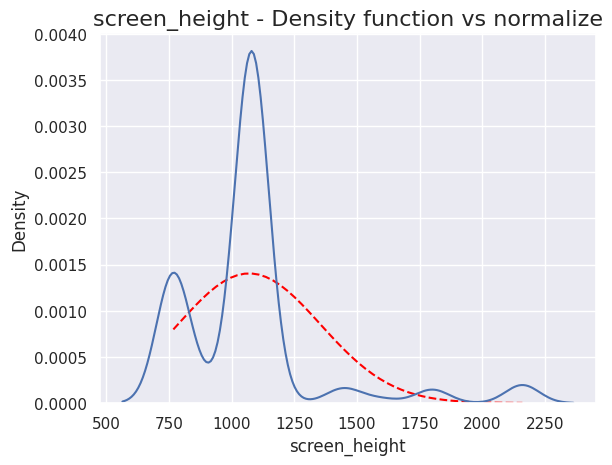

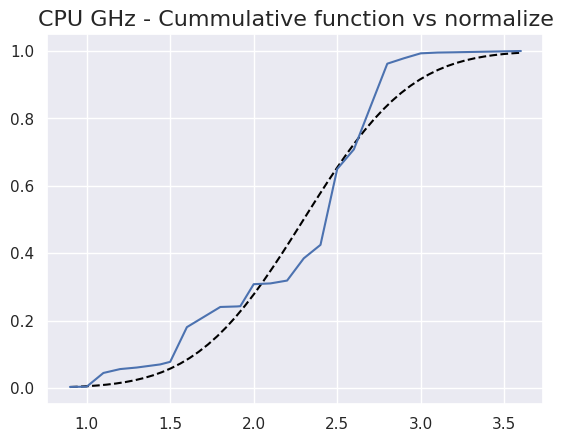

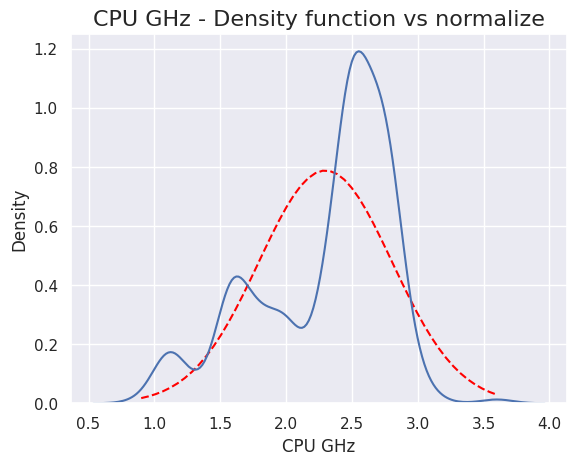

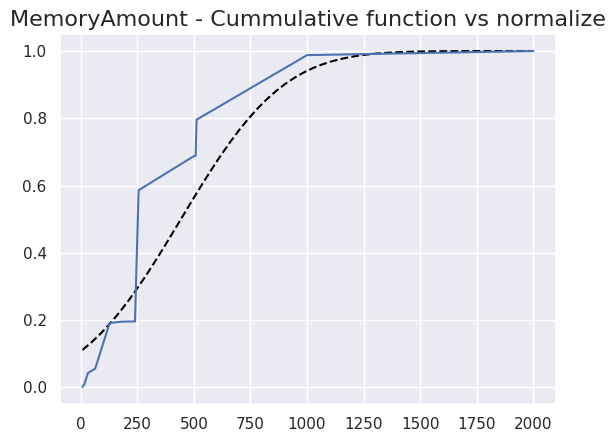

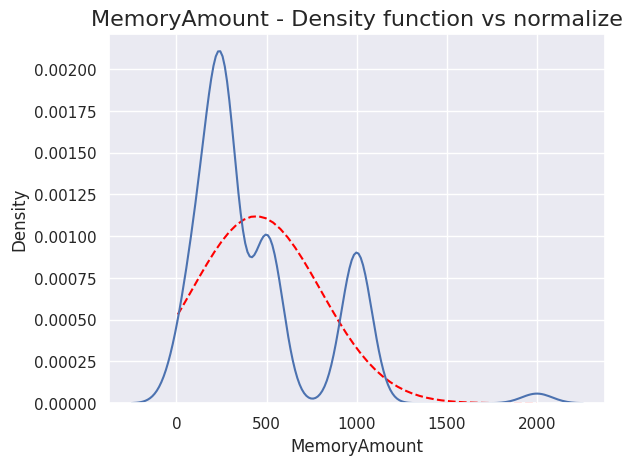

In [132]:
def NormVSReal(df):
    columns=df.select_dtypes(include=np.number)
    for column in columns:
        stats = df[column].describe()
        xs = np.linspace(stats['min'],stats['max'])
        ys= scipy.stats.norm(stats['mean'],stats['std']).cdf(xs)
        zs= scipy.stats.norm(stats['mean'],stats['std']).pdf(xs)
        
        
        plt.plot(xs,ys,color='black',linestyle='dashed')
        empiricaldist.Cdf.from_seq(
            df[column],
            normalize=True
        ).plot()
        plt.title(f'{column} - Cummulative function vs normalize',fontsize=Title_fontsize)
        plt.show()
        
        plt.plot(xs,zs,color='red',linestyle='dashed')

        sns.kdeplot(
            data=df,
            x=column
        )

        plt.title(f'{column} - Density function vs normalize',fontsize=Title_fontsize)
        plt.show()

NormVSReal(df=laptop,)

# Bivariate Analysis

In [133]:
laptop.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
0,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1339.69,2560,1600,True,Intel,2.30,128,SSD
1,Apple,Ultrabook,13.30,8,Intel,macOS,1.34,898.94,1440,900,False,Intel,1.80,128,Flash
2,HP,Notebook,15.60,8,Intel,No OS,1.86,575.00,1920,1080,False,Intel,2.50,256,SSD
3,Apple,Ultrabook,15.40,16,AMD,macOS,1.83,2537.45,2880,1800,True,Intel,2.70,512,SSD
4,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1803.60,2560,1600,True,Intel,3.10,256,SSD


In [134]:
def boxplot(df,num_column):
    categories = df.select_dtypes(include='object')
    for category in categories:
        plt.figure(figsize=(12,6))
        sns.boxplot(
            data=laptop,
            x=category,
            y=num_column
        )

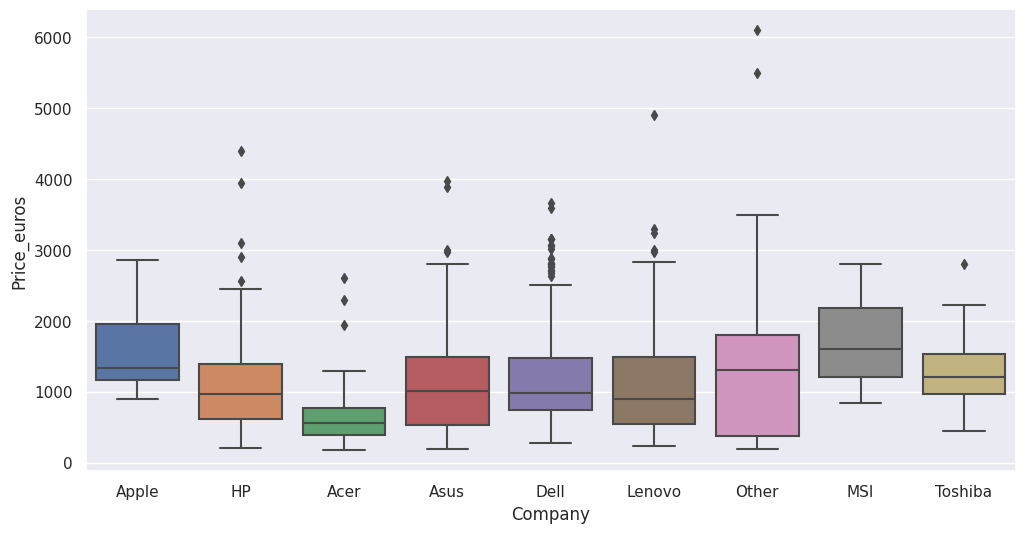

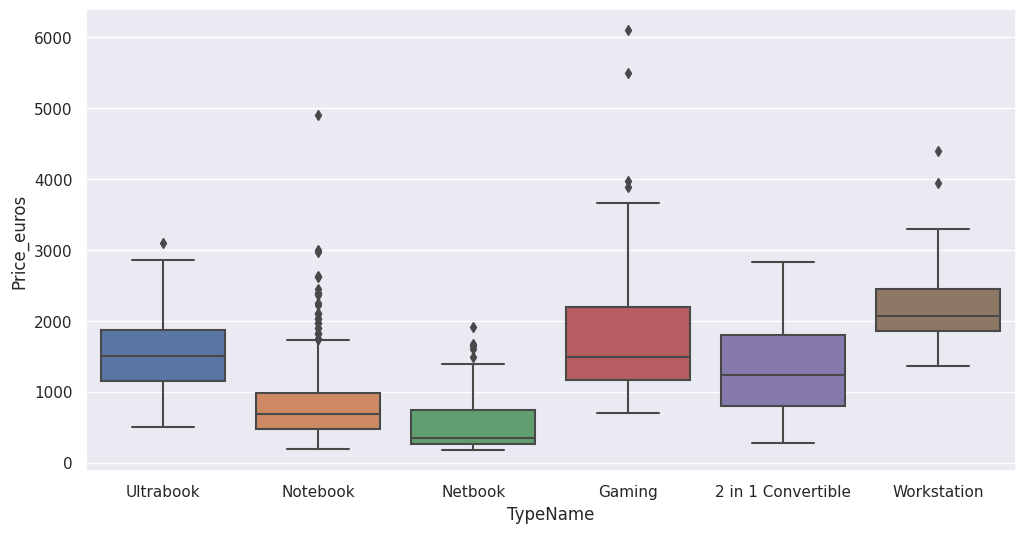

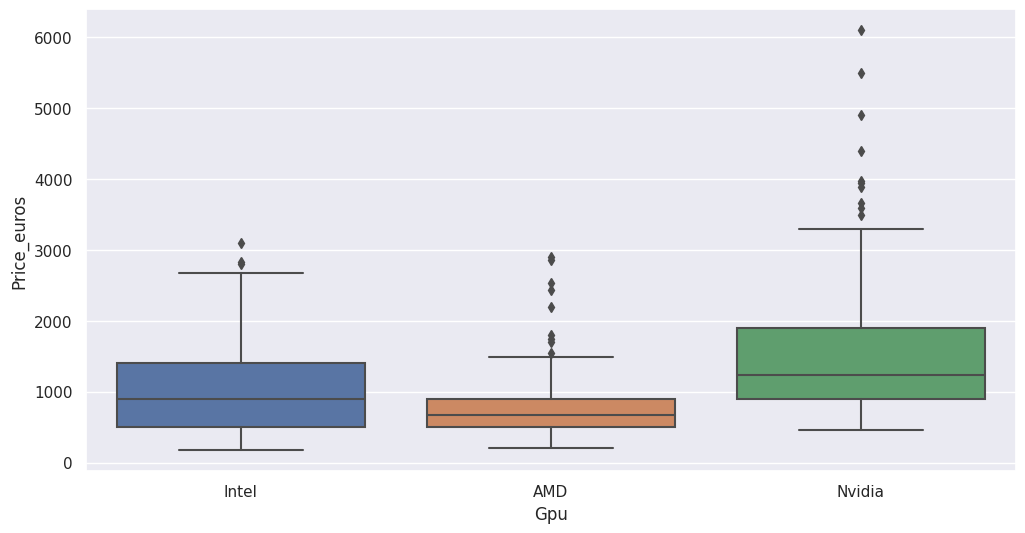

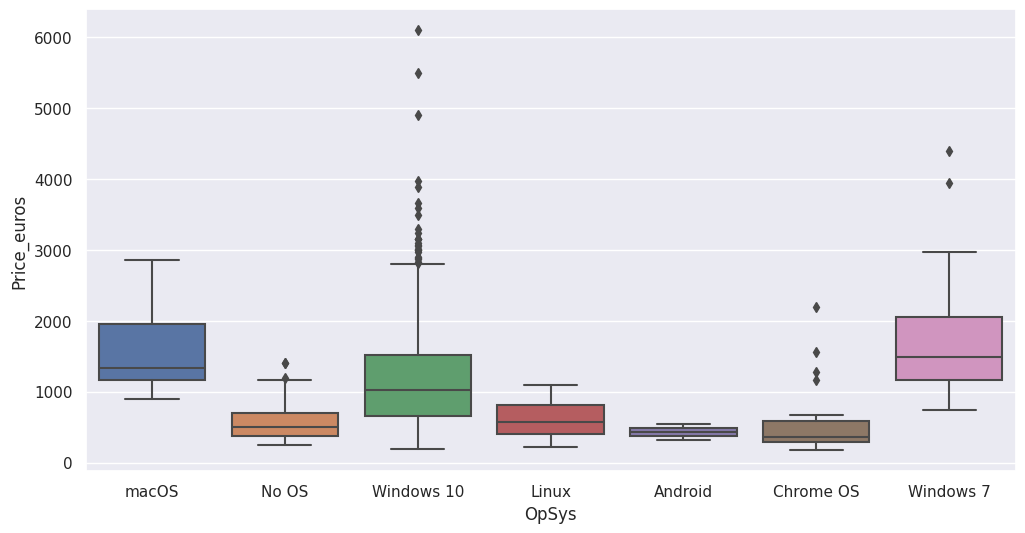

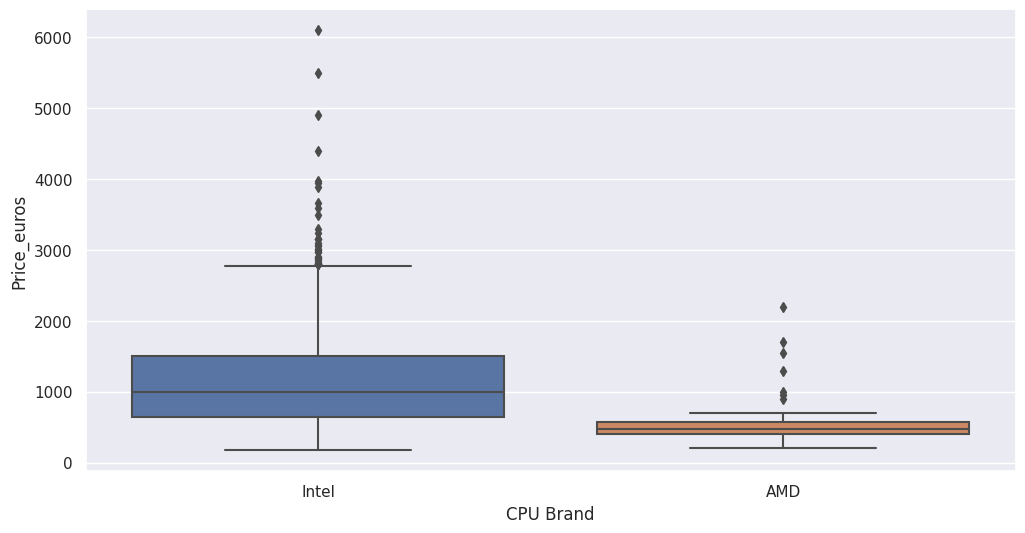

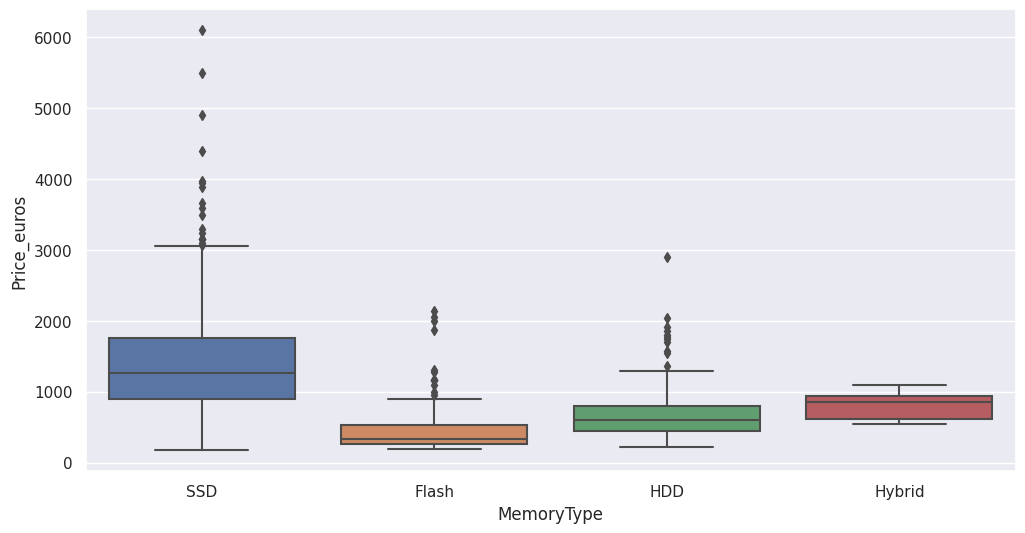

In [135]:
boxplot(df=laptop,num_column='Price_euros')

In [136]:
# This row is the only one with CPU Brand = Samsung and GPU = ARM, so it just add more noise to our analysis
# laptop[laptop['CPU Brand']=='Samsung']

## Relationship between variables

In [138]:
laptop.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
0,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1339.69,2560,1600,True,Intel,2.30,128,SSD
1,Apple,Ultrabook,13.30,8,Intel,macOS,1.34,898.94,1440,900,False,Intel,1.80,128,Flash
2,HP,Notebook,15.60,8,Intel,No OS,1.86,575.00,1920,1080,False,Intel,2.50,256,SSD
3,Apple,Ultrabook,15.40,16,AMD,macOS,1.83,2537.45,2880,1800,True,Intel,2.70,512,SSD
4,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1803.60,2560,1600,True,Intel,3.10,256,SSD


In [144]:
def Scatter(df,value):
    columns = df.select_dtypes(include=np.number)
    columns=columns.drop(value,axis=1)
    for column in columns:
        sns.scatterplot(
            data=laptop,
            x=value,
            y=column,
            alpha=1/2,
            s=50
            )
        plt.show()

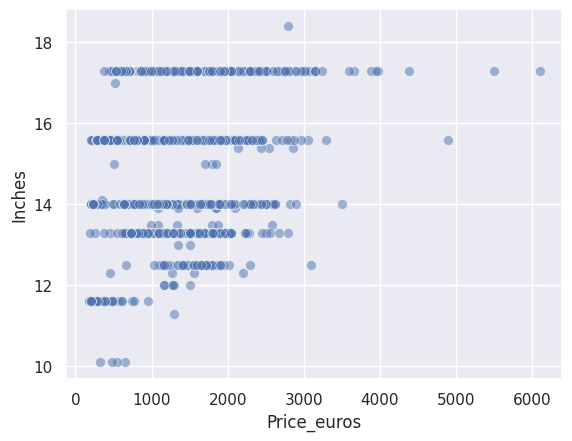

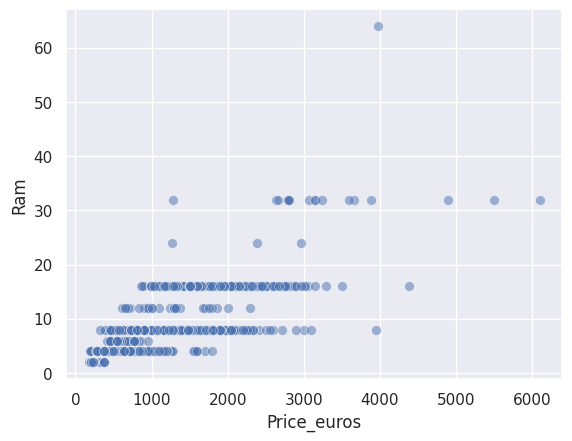

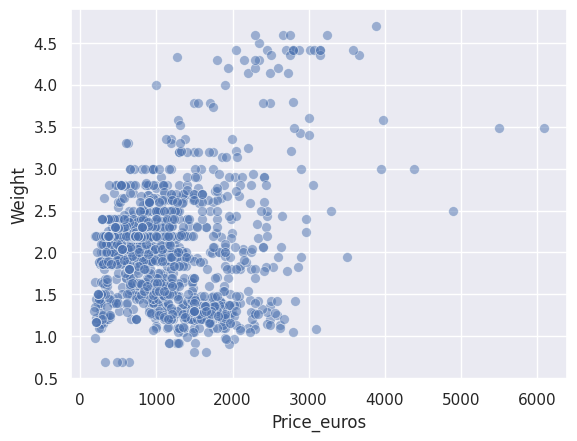

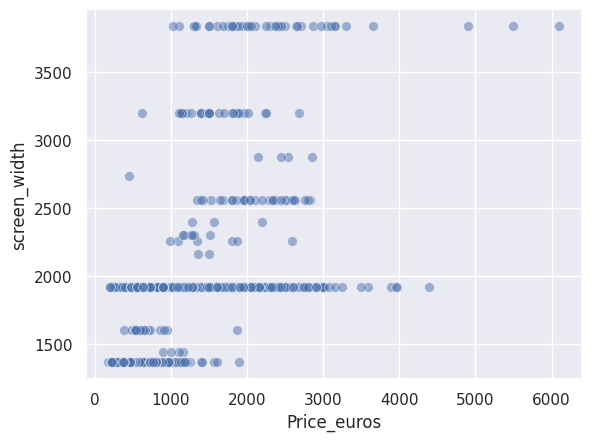

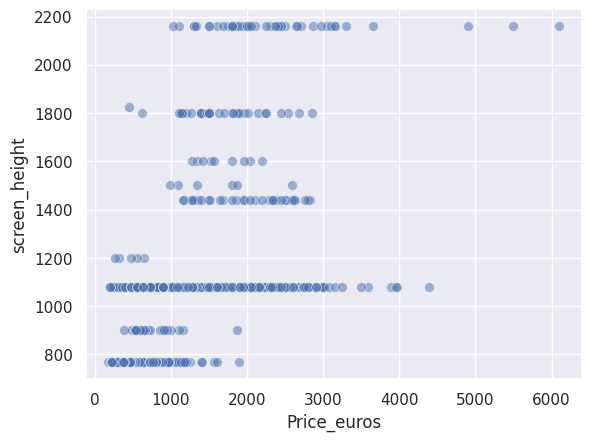

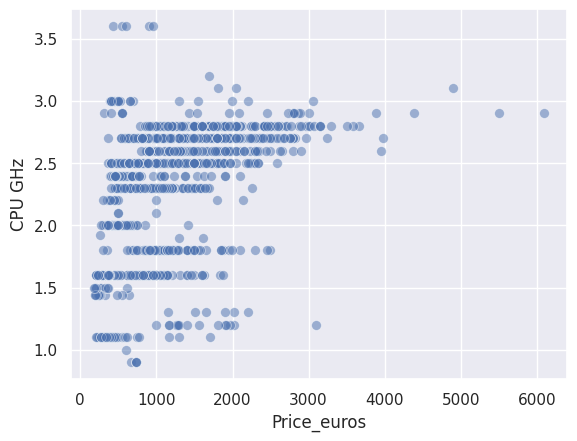

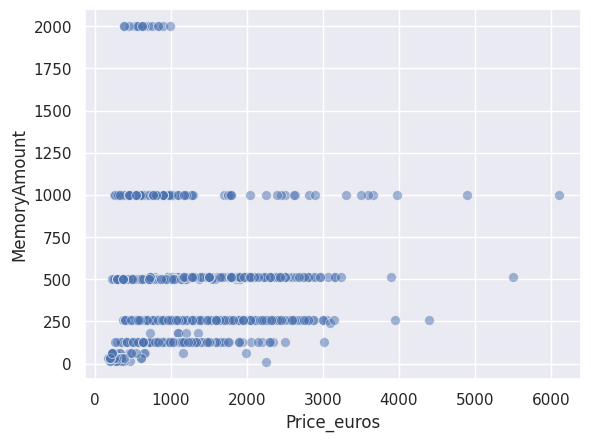

In [145]:
Scatter(df=laptop,value='Price_euros')

## Correlation

In [150]:
laptop.corr().style.highlight_between(left=0.60, right=.99,color='green')

,Inches,Ram,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU GHz,MemoryAmount
Inches,1.000000,0.237129,0.827397,0.067329,-0.069875,-0.092934,-0.112726,0.307476,0.268335
Ram,0.237129,1.000000,0.383362,0.742905,0.434095,0.426357,0.207949,0.367764,0.017522
Weight,0.827397,0.383362,1.000000,0.209867,-0.031866,-0.052041,0.018643,0.320090,0.178992
Price_euros,0.067329,0.742905,0.209867,1.000000,0.557369,0.554591,0.253320,0.430122,-0.123038
screen_width,-0.069875,0.434095,-0.031866,0.557369,1.000000,0.994480,0.280588,0.184110,-0.073054
screen_height,-0.092934,0.426357,-0.052041,0.554591,0.994480,1.000000,0.287404,0.170761,-0.079478
IPS Panel,-0.112726,0.207949,0.018643,0.253320,0.280588,0.287404,1.000000,0.063833,-0.118008
CPU GHz,0.307476,0.367764,0.320090,0.430122,0.184110,0.170761,0.063833,1.000000,0.065815
MemoryAmount,0.268335,0.017522,0.178992,-0.123038,-0.073054,-0.079478,-0.118008,0.065815,1.000000


<AxesSubplot:>

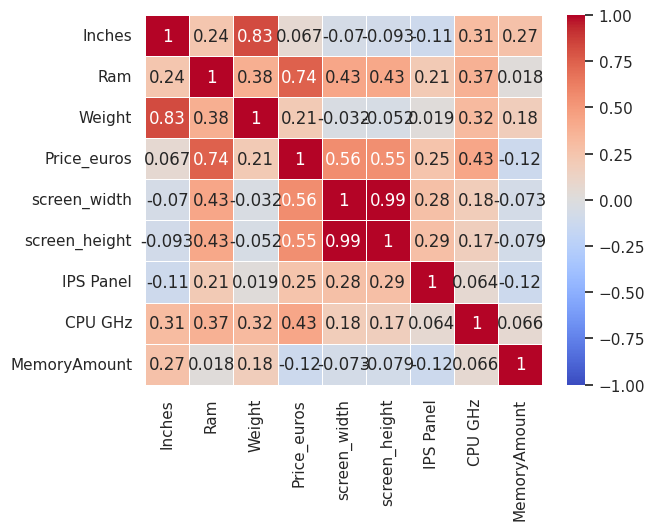

In [151]:
sns.heatmap(
    data=laptop.corr(),
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot=True
)

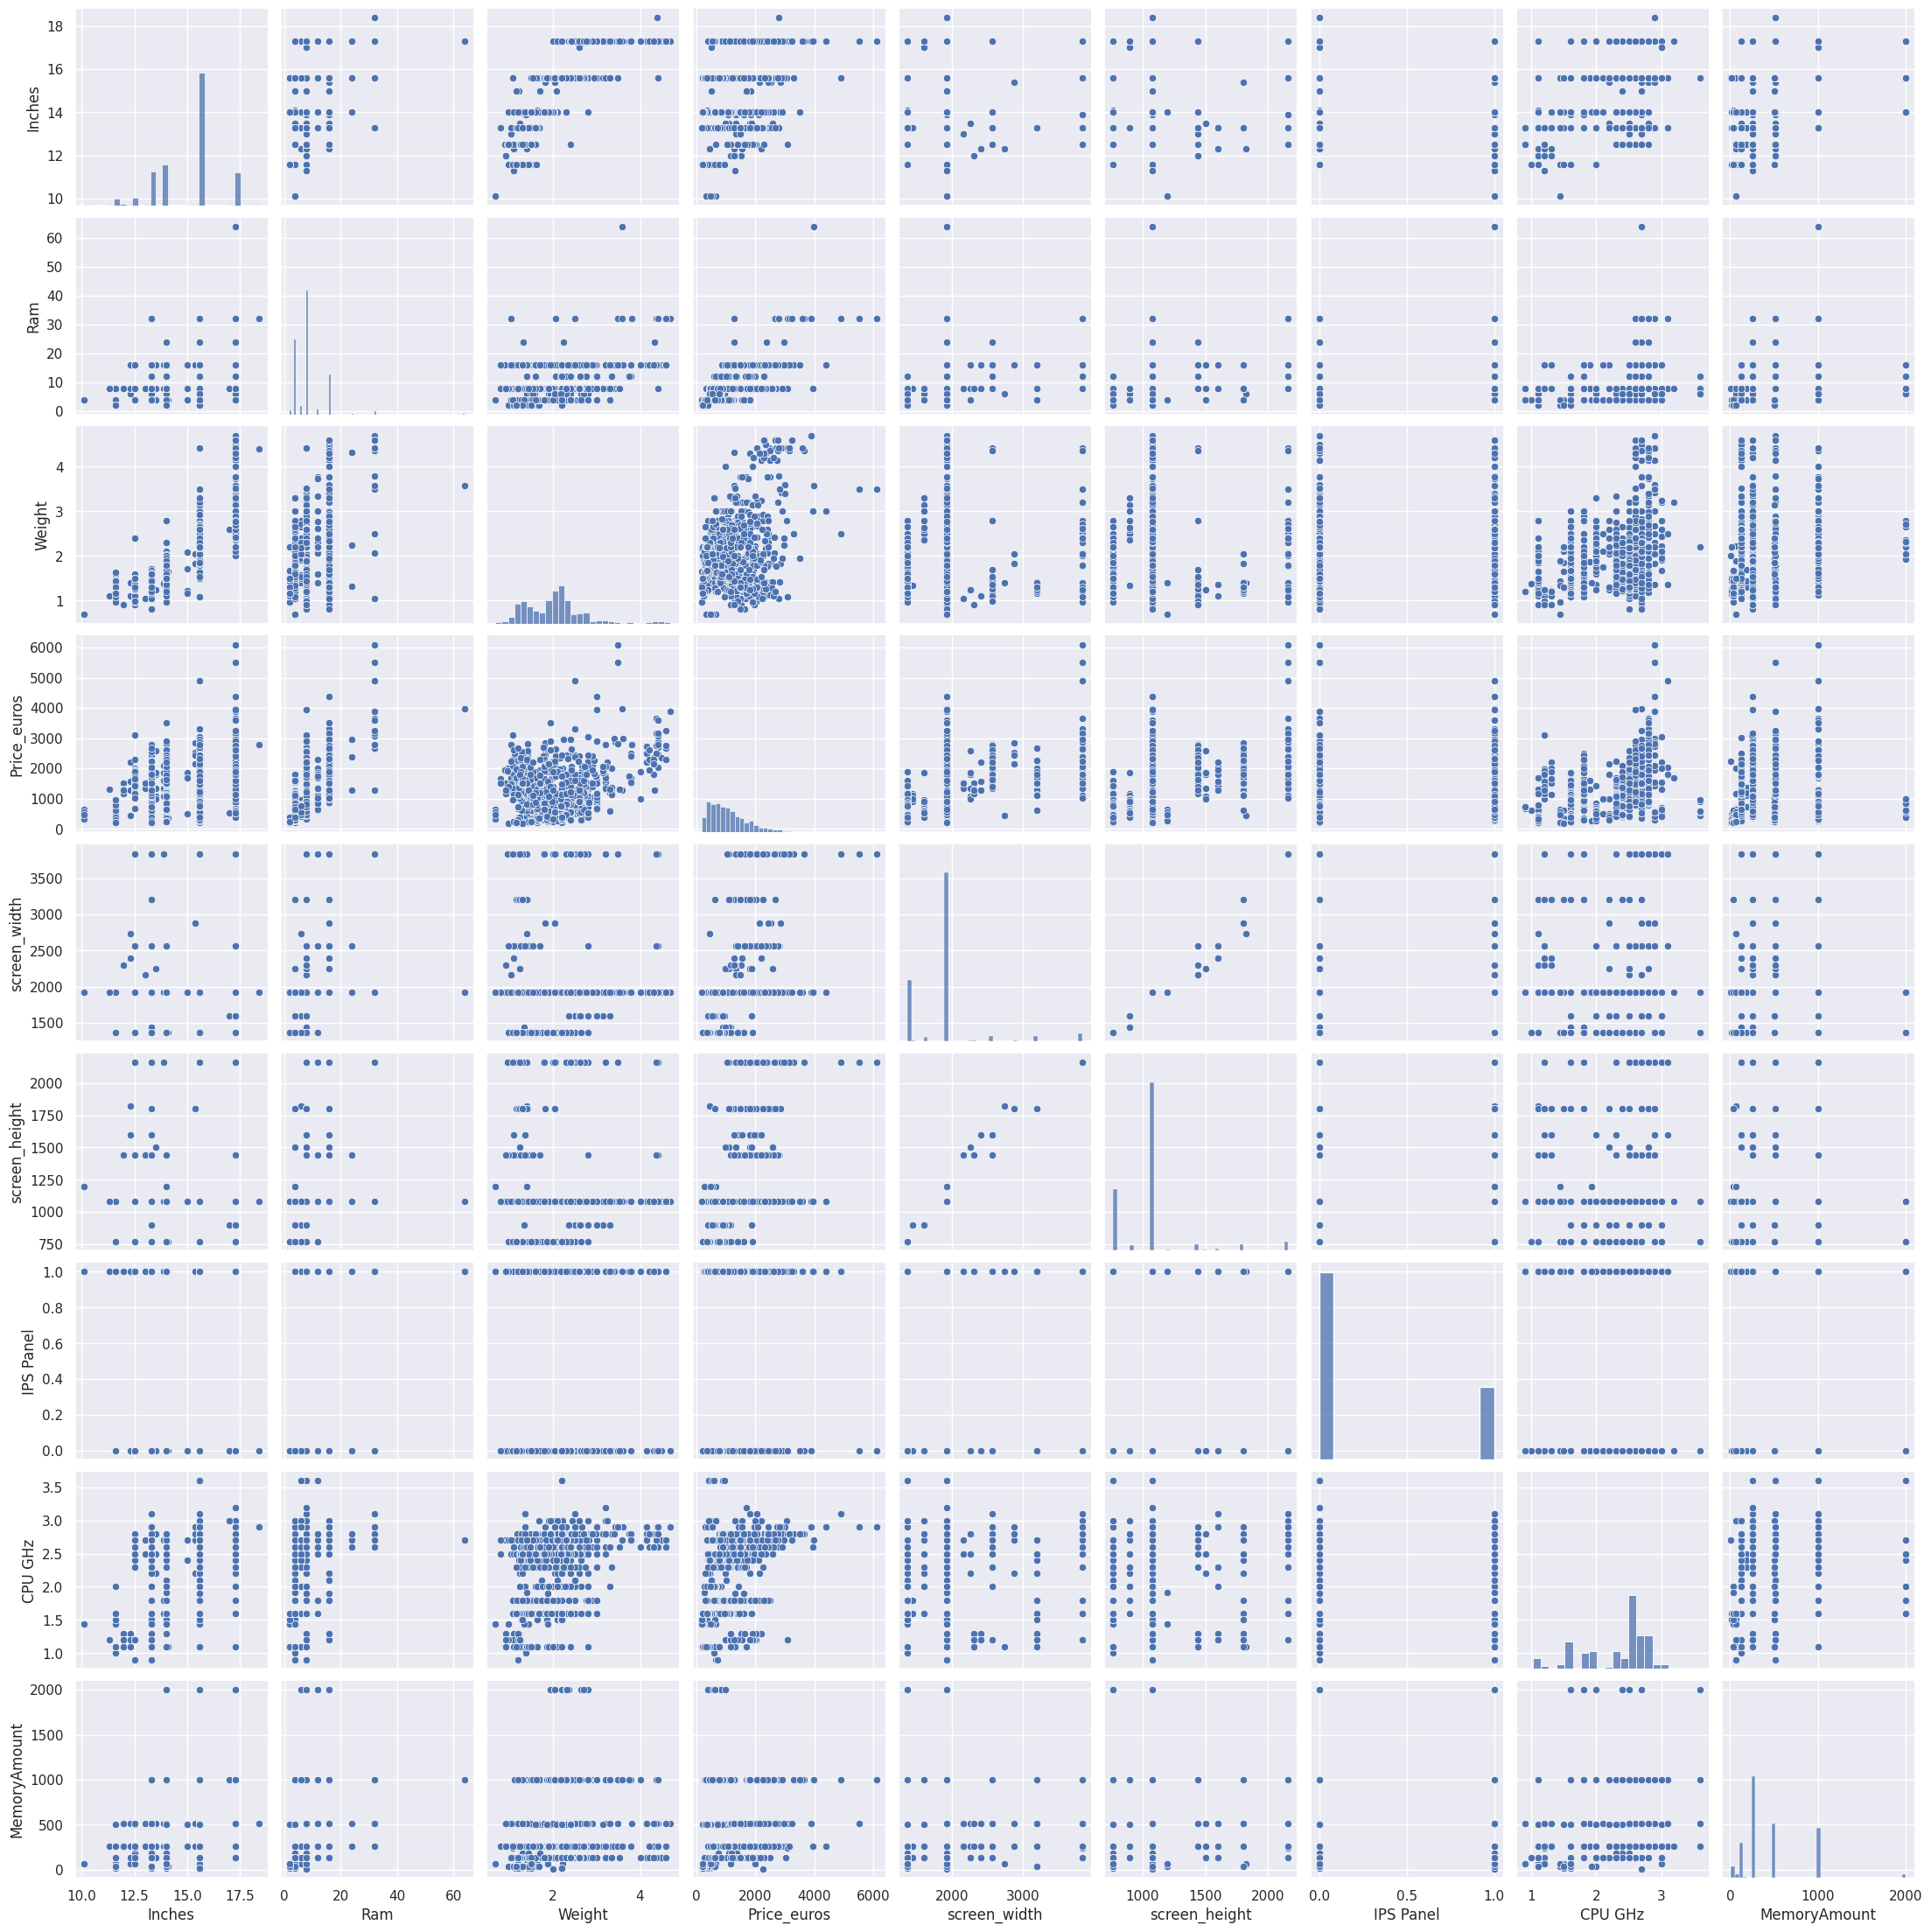

In [156]:
sns.pairplot(
    data=laptop
)

## Linear Regression

In [153]:
laptop.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
0,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1339.69,2560,1600,True,Intel,2.30,128,SSD
1,Apple,Ultrabook,13.30,8,Intel,macOS,1.34,898.94,1440,900,False,Intel,1.80,128,Flash
2,HP,Notebook,15.60,8,Intel,No OS,1.86,575.00,1920,1080,False,Intel,2.50,256,SSD
3,Apple,Ultrabook,15.40,16,AMD,macOS,1.83,2537.45,2880,1800,True,Intel,2.70,512,SSD
4,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1803.60,2560,1600,True,Intel,3.10,256,SSD


In [154]:
x = laptop.Ram
y = laptop.Price_euros

reg = scipy.stats.linregress(x=x,y=y)

print(reg)

LinregressResult(slope=102.14191577196048, intercept=267.52666175248487, rvalue=0.7429050080846187, pvalue=7.285321722272769e-229, stderr=2.552599644257939, intercept_stderr=25.030667947024643)


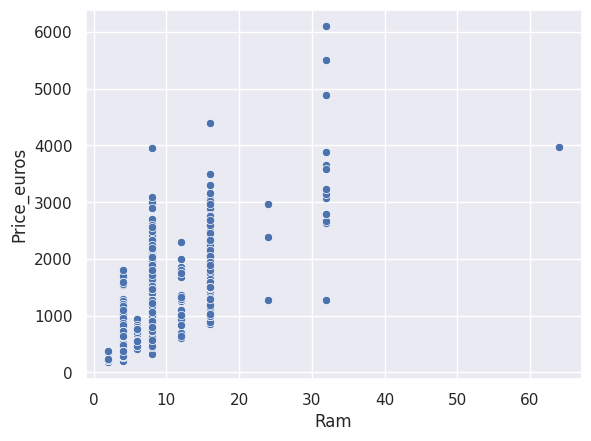

In [155]:
sns.scatterplot(
    data=laptop,
    x=x,
    y=y
)

fx=np.array(x.min(),x.max())
fy= reg.intercept + reg.slope * fx
plt.plot(fx,fy,color='red')
plt.show()

## Multiple Regression

In [188]:
model_1 = (
    smf.ols(
        formula='Price_euros ~ Ram',
        data=laptop
    ).fit()
)
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     1601.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          7.29e-229
Time:                        02:53:47   Log-Likelihood:                -9852.3
No. Observations:                1302   AIC:                         1.971e+04
Df Residuals:                    1300   BIC:                         1.972e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    267.5267     25.031     10.688      0.000     218.422     316.632
Ram          102.1419      2.553     40.015      0.000      97.134     107.150
==============================================================================
Omnibus:                      273.908   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1178.498
Skew:                           0.935   Prob(JB):                    1.24e-256
Kurtosis:                       7.269   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
model_2 = (
    smf.ols(
        formula='Price_euros ~ Ram + C(Gpu) + screen_width + C(TypeName)',
        data=laptop
    ).fit()
)
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     341.6
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:53:39   Log-Likelihood:                -9582.1
No. Observations:                1302   AIC:                         1.918e+04
Df Residuals:                    1292   BIC:                         1.924e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -189.4883     69.731     -2.717      0.007    -326.287     -52.690
C(Gpu)[T.Intel]              161.0811     33.237      4.846      0.000      95.877     226.285
C(Gpu)[T.Nvidia]             129.6390     39.290      3.300      0.001      52.559     206.719
C(TypeName)[T.Gaming]         98.6747     53.949      1.829      0.068      -7.162     204.511
C(TypeName)[T.Netbook]      -140.9702     85.476     -1.649      0.099    -308.656      26.716
C(TypeName)[T.Notebook]     -184.1085     40.059     -4.596      0.000    -262.696    -105.521
C(TypeName)[T.Ultrabook]     200.0406     44.289      4.517      0.000     113.155     286.926
C(TypeName)[T.Workstation]   882.9311     83.282     10.602      0.000     719.548    1046.314
Ram                           74.8738      2.686     27.879      0.000      69.605      80.142
screen_width                   0.3150      0.025     12.563      0.000       0.266       0.364
==============================================================================
Omnibus:                      286.752   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1148.146
Skew:                           1.005   Prob(JB):                    4.82e-250
Kurtosis:                       7.138   Cond. No.                     2.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [187]:
model_3 = (
    smf.ols(
        formula='Price_euros ~ Ram + Weight + C(Gpu) + screen_width',
        data=laptop
    ).fit()
)
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     447.5
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          3.42e-279
Time:                        02:53:41   Log-Likelihood:                -9722.0
No. Observations:                1302   AIC:                         1.946e+04
Df Residuals:                    1296   BIC:                         1.949e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -479.4981     80.455     -5.960      0.000    -637.334    -321.663
C(Gpu)[T.Intel]    215.6622     37.403      5.766      0.000     142.286     289.039
C(Gpu)[T.Nvidia]   254.1867     40.418      6.289      0.000     174.895     333.478
Ram                 83.7232      2.905     28.819      0.000      78.024      89.423
Weight             -18.7139     24.021     -0.779      0.436     -65.839      28.411
screen_width         0.3917      0.027     14.251      0.000       0.338       0.446
==============================================================================
Omnibus:                      303.501   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1251.866
Skew:                           1.056   Prob(JB):                    1.45e-272
Kurtosis:                       7.314   Cond. No.                     1.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [189]:
model_results=pd.DataFrame(
    dict(
        actual_value = laptop.Price_euros,
        predict_value1 = model_1.predict(),
        predict_value2 = model_2.predict(),
        predict_value3 = model_3.predict()
    )
)
model_results

,actual_value,predict_value1,predict_value2,predict_value3
0,1339.69,1084.66,1576.99,1382.96
1,898.94,1084.66,1224.21,944.86
2,575.00,1084.66,991.25,1123.13
3,2537.45,1901.80,2115.70,1953.81
4,1803.60,1084.66,1576.99,1382.96
...,...,...,...,...
1297,638.00,676.09,875.87,789.36
1298,1499.00,1901.80,2177.54,2304.72
1299,229.00,471.81,367.51,410.55
1300,764.00,880.38,505.92,516.86


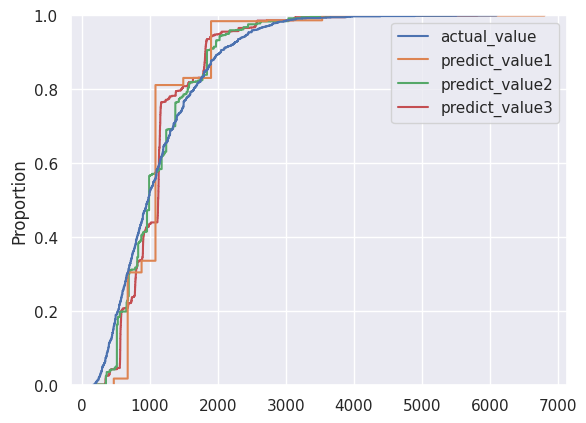

In [190]:
sns.ecdfplot(
    data=model_results,
    
)
plt.show()

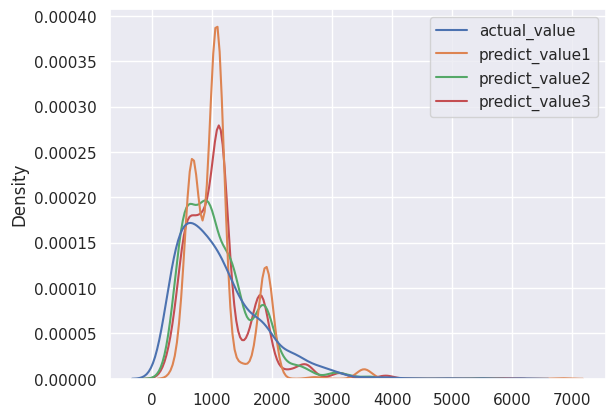

In [191]:
sns.kdeplot(
    data=model_results
)
plt.show()